In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_network, Flatten, View, weight_reset, set_seed, LanguageNameDataset

/tmp/ipykernel_10205/78206994.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

/tmp/ipykernel_26618/2465435892.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [3]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [4]:
def getLayer(in_size, out_size):
    """
    in_size: how many neurons/features are coming into this layer
    out_size: how many neurons/outputs this hidden layer should produce
    """
    return nn.Sequential(
        nn.Linear(in_size, out_size),
        nn.BatchNorm1d(out_size),
        nn.ReLU())

def encode_batch(encoder, dataset_to_encode):
    """
    encoder: the PyTorch network that takes in a dataset and converts it to
    ➥ a new dimension
    dataset_to_encode: a PyTorch 'Dataset' object that we want to convert.

    Returns a tuple (projected, labels) where 'projected' is the encoded
    ➥ version of the dataset, and 'labels' are the original labels
    ➥ provided by the 'dataset_to_encode'
    """
    projected = []
    labels = []

    encoder = encoder.eval()
    encoder = encoder.cpu()


    with torch.no_grad():
        for x, y in DataLoader(dataset_to_encode, batch_size=128):
            z = encoder(x.cpu())
            projected.append( z.numpy() )
            labels.append( y.cpu().numpy().ravel() )

    projected = np.vstack(projected)

    labels = np.hstack(labels)
    return projected, labels

def showEncodeDecode(encode_decode, x):
    """
    encode_decode: the PyTorch Module that does the encoding and decoding
    ➥ steps at once
    x: the input to plot as is, and after encoding & decoding it
    """

    encode_decode = encode_decode.eval()
    encode_decode = encode_decode.cpu()
    with torch.no_grad():
        x_recon = encode_decode(x.cpu())
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0,:])
    axarr[1].imshow(x_recon.numpy()[0,0,:])

class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs.
    This makes it easy to reuse other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Create a new version of the MNIST dataset that does not contain the numbers 9 and 5, and train one of the autoencoders on this dataset. Then run the autoencoder on the test dataset, and record the average error (MSE) for each of the 10 classes. Do you see any patterns in the results, and can the autoencoder identify 9 and 5 as outliers?

In [5]:
D = 28*28
n = 2
C = 1
classes = 10
mse_loss = nn.MSELoss()

In [6]:
# filter data
# train_data = AutoEncodeDataset(torchvision.datasets.MNIST("./data", train=True,transform=transforms.ToTensor(), download=True))
#
# test_data_xy = torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)
# test_data_xx = AutoEncodeDataset(test_data_xy)

train_dataset = torchvision.datasets.MNIST("./data", train = True, download = True, transform = transforms.ToTensor())

test_data_xy = torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)

# select all classes without 5 and 9
idx = (train_dataset.targets==0) | (train_dataset.targets==1) | (train_dataset.targets==2) | (train_dataset.targets==3) | (train_dataset.targets==4) | (train_dataset.targets==6) | (train_dataset.targets==7) | (train_dataset.targets==8)

train_dataset.targets = train_dataset.targets[idx]
train_dataset.data = train_dataset.data[idx]

# select all classes without 5 and 9
idx = (test_data_xy.targets==0) | (test_data_xy.targets==1) | (test_data_xy.targets==2) | (test_data_xy.targets==3) | (test_data_xy.targets==4) | (test_data_xy.targets==6) | (test_data_xy.targets==7) | (test_data_xy.targets==8)

test_data_xy.targets = test_data_xy.targets[idx]
test_data_xy.data = test_data_xy.data[idx]

# generate my dataset
train_data = AutoEncodeDataset(train_dataset)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

In [8]:
auto_encoder = nn.Sequential(
    nn.Flatten(),
    getLayer(D, D//2),
    getLayer(D//2, D//3),
    getLayer(D//3, D//4),
    nn.Linear(D//4, n),
)

auto_decoder = nn.Sequential(
    getLayer(n, D//4),
    getLayer(D//4, D//3),
    getLayer(D//3, D//2),

    nn.Linear(D//2, D),
    View(-1, 1, 28, 28)
)
auto_encode_decode = nn.Sequential(
    auto_encoder,
    auto_decoder
)

In [9]:
result = train_network(auto_encode_decode, mse_loss, train_loader,test_loader=test_loader, epochs=30, device=device)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/380 [00:00<?, ?it/s]

Testing:   0%|          | 0/64 [00:00<?, ?it/s]

In [10]:
test_data_xy = torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)

# my loss calulation
loss_lst= []
loss_fn = nn.MSELoss(reduction='mean') #reduction=mean
auto_encode_decode.eval()
with torch.no_grad():
    for data, label in test_data_xy:
        data = data.to(device)
        auto_encode_decode_result = auto_encode_decode(data)
        # (1,1,28,28) ->  (1,28,28) so lets use [0] to adapt to the right shape
        loss_each = loss_fn(data, auto_encode_decode_result[0])

        l = len([[ix, iy] for ix, row in enumerate(loss_lst) for iy, el in enumerate(row) if el == label])

        # .item() converts torch to a float
        if l == 0:
            loss_lst.append([label,loss_each.item()])
        else:
            idx = [[ix, iy] for ix,row in enumerate(loss_lst) for iy, el in enumerate(row) if el==label][0][0]
            loss_lst[idx][1] = ((loss_lst[idx][1]+loss_each.item())/2)

weak_mean = [[row[0], row[1]] for ix, row in enumerate(loss_lst) if row[1] > 0.05]
df = pd.DataFrame(weak_mean, columns=['digit', 'mean'])
df.sort_values(by=['digit'], ascending=True)

,digit,mean
0,2,0.055323
1,5,0.058673


In [11]:
print(loss_lst)

[[7, 0.020662286709777197], [2, 0.05532283302179551], [1, 0.008489813994316885], [0, 0.04530997659755799], [4, 0.02503837958891842], [9, 0.04522132920455374], [5, 0.058672549094752224], [6, 0.029749068071070243], [3, 0.04235079803663621], [8, 0.042927799801879565]]


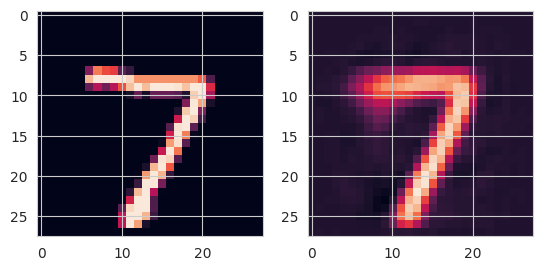

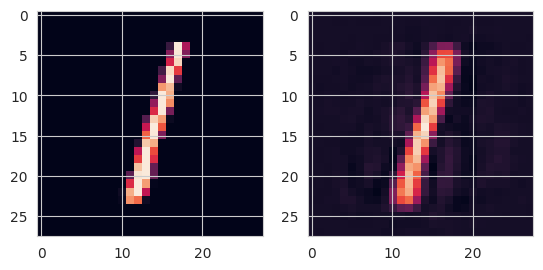

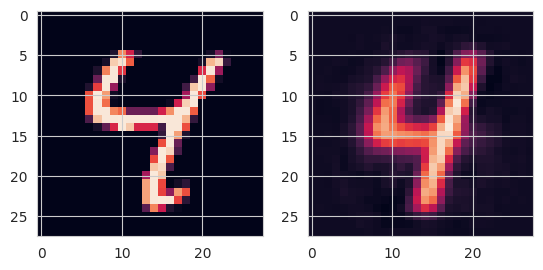

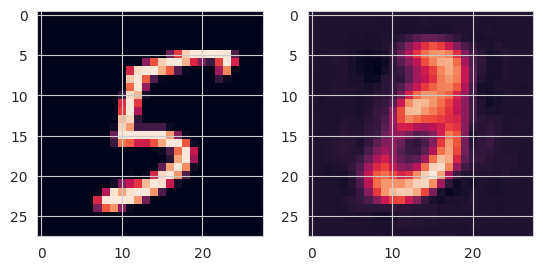

In [12]:
showEncodeDecode(auto_encode_decode, test_data_xy[0][0])
showEncodeDecode(auto_encode_decode, test_data_xy[2][0])
showEncodeDecode(auto_encode_decode, test_data_xy[6][0])
showEncodeDecode(auto_encode_decode, test_data_xy[23][0])

Model seems to be too week to do some conclusion because 2 seems to get also a very high rate like 5. Only number 1 is well classified :)

### Train the bottleneck-style autoencoder with a target size D′ = 64 dimensions. Then use k-means (https://scikit-learn.org/stable/modules/clustering.html#k-means)to create k = 10 clusters on the original version of MNIST and the version encoded using D′ = 64 dimensions. Use the homogeneity score from scikit-learn (http://mng.bz/nYQV) to evaluate these clusters. Which method does best:k-means on the original images or k-means on the encoded representations?

In [6]:
D = 28*28
n = 64
C = 1
classes = 10
mse_loss = nn.MSELoss()

In [7]:
class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs.
    This makes it easy to reuse other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x

In [8]:
class TransposeLinear(nn.Module):
    def __init__(self, linearLayer, bias=True):
        """
        linearLayer: is the layer that we want to use the transpose of to
        ➥ produce the output of this layer. So the Linear layer represents
        ➥ W, and this layer represents W^T. This is accomplished via
        ➥ weight sharing by reusing the weights of linearLayer
        bias: if True, we will create a new bias term b that is learned
        separately from what is in
        linearLayer. If false, we will not use any bias vector.
        """
        super().__init__()
        self.weight = linearLayer.weight

        if bias:
            self.bias = nn.Parameter(torch.Tensor(linearLayer.weight.shape[1]))
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        return F.linear(x, self.weight.t(), self.bias)



In [9]:
linearLayer = nn.Linear(D, n, bias=False)

pca_encoder = nn.Sequential(
    nn.Flatten(), linearLayer,
)

pca_decoder = nn.Sequential(
    TransposeLinear(linearLayer, bias=False),
    View(-1, 1, 28, 28)
)
pca_model = nn.Sequential(
    pca_encoder,
    pca_decoder
)

In [10]:
train_data = AutoEncodeDataset(torchvision.datasets.MNIST("./data", train=True,transform=transforms.ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

In [11]:
mse_loss = nn.MSELoss()

def mseWithOrthoLoss(x, y):
    W = linearLayer.weight
    I = torch.eye(W.shape[0]).to(device)

    normal_loss = mse_loss(x, y)

    regularization_loss = 0.1*mse_loss(torch.mm(W, W.t()), I)

    return normal_loss + regularization_loss

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [12]:
train_network(pca_model, mseWithOrthoLoss, train_loader, test_loader=test_loader, epochs=10, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss
0,0,7.806696,0.022548,0.011174
1,1,15.144869,0.010308,0.009510
2,2,22.726623,0.009640,0.009326
3,3,30.058259,0.009546,0.009262
4,4,37.219180,0.009522,0.009236
5,5,44.307374,0.009514,0.009232
6,6,51.473370,0.009509,0.009248
7,7,58.447121,0.009507,0.009246
8,8,65.355313,0.009507,0.009238
9,9,72.301211,0.009505,0.009227


In [13]:
# original
from sklearn.cluster import KMeans
import numpy as np

# transform input dataset
nsamples, nx, ny = test_data_xy.data.numpy().shape
test_dataset = test_data_xy.data.numpy().reshape((nsamples,nx*ny))

kmeans = KMeans(n_clusters=10, random_state=42, algorithm='lloyd').fit(test_dataset)
#kmeans.labels_
y_pred_test = kmeans.predict(test_dataset)

In [14]:
# use trained pca_encoder model
test_projected, test_labels = encode_batch(pca_model, test_data_xy)

nsamples, d, nx, ny = test_projected.shape
test_dataset = test_projected.reshape((nsamples,d*nx*ny))

# encoded version
kmeans_enc = KMeans(n_clusters=10, random_state=42, algorithm='lloyd').fit(test_dataset)
#kmeans.labels_
y_pred_test_projected = kmeans_enc.predict(test_dataset)

In [15]:
from sklearn import metrics
labels_true = test_data_xy.targets.numpy()
labels_pred = y_pred_test
labels_pred_encoded = y_pred_test_projected

print("Homogeneity Score KMeans: "+str(metrics.homogeneity_score(labels_true, labels_pred)))
print("Completeness Score KMeans: "+str(metrics.completeness_score(labels_true, labels_pred)))
print("Measure Score KMeans: "+str(metrics.v_measure_score(labels_true, labels_pred)))

print("Homogeneity Score KMeans Encoded: "+str(metrics.homogeneity_score(labels_true, labels_pred_encoded)))
print("Completeness Score KMeans Encoded: "+str(metrics.completeness_score(labels_true, labels_pred_encoded)))
print("Measure Score KMeans Encoded: "+str(metrics.v_measure_score(labels_true, labels_pred_encoded)))

Homogeneity Score KMeans: 0.4999214185498519
Completeness Score KMeans: 0.5031013695031268
Measure Score KMeans: 0.5015063532197471
Homogeneity Score KMeans Encoded: 0.5036382143781774
Completeness Score KMeans Encoded: 0.5067360467670226
Measure Score KMeans Encoded: 0.5051823815573695


Encoder seems to help it performs a little bit better

### Use the denoising approach to implement a denoising convolutional network. This can be done by not having any pooling operations so that the input stays the same size.

In [6]:
D = 28*28
H = 8
n = 2
C = 1
classes = 10
mse_loss = nn.MSELoss()

In [7]:
train_data = AutoEncodeDataset(torchvision.datasets.MNIST("./data", train=True,transform=transforms.ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

In [8]:
normal = torch.distributions.Normal(0, 0.5)

In [9]:
def getLayer(in_size, out_size):
    """
    in_size: how many neurons/features are coming into this layer
    out_size: how many neurons/outputs this hidden layer should produce
    """
    return nn.Sequential(
        nn.Conv2d(in_size, out_size, kernel_size=3, padding=3//2),
        nn.BatchNorm2d(out_size),
        nn.ReLU())

In [10]:
def addNoise(x, device='cpu'):
    """
    We will use this helper function to add noise to some data.
    x: the data we want to add noise to
    device: the CPU or GPU that the input is located on.
    """
    return x + normal.sample(sample_shape= torch.Size(x.shape)).to(device)

In [11]:
class AdditiveGaussNoise(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        if self.training:
            return addNoise(x, device=device)
        else:
            return x

In [12]:
dnauto_encoder_big = nn.Sequential(
    AdditiveGaussNoise(),
    getLayer(1, H),
    getLayer(H, H*2),
    getLayer(H*2, H*2),
    nn.Conv2d(H*2, H*2, kernel_size=3, padding=3//2),
)

dnauto_decoder_big = nn.Sequential(
    getLayer(H*2, H*2),
    getLayer(H*2, H),
    nn.Conv2d(H, 1, kernel_size=3, padding=3//2),
    nn.Flatten(),
    nn.Linear(D, D),
    View(-1, 1, 28, 28)
)

dnauto_encode_decode_big = nn.Sequential(
    dnauto_encoder_big,
    dnauto_decoder_big
)

result = train_network(dnauto_encode_decode_big, mse_loss, train_loader, test_loader=test_loader, epochs=10, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

In [13]:
def showEncodeDecode(encode_decode, x):
    """
    encode_decode: the PyTorch Module that does the encoding and decoding
    ➥ steps at once
    x: the input to plot as is, and after encoding & decoding it
    """

    encode_decode = encode_decode.eval()
    encode_decode = encode_decode.cpu()
    with torch.no_grad():
        tensor4d=x.unsqueeze(1) #add new dimension at position 1
        x_recon = encode_decode(tensor4d.cpu())
        #x_recon = encode_decode(x.cpu())

    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0,:])
    axarr[1].imshow(x_recon.numpy()[0,0,:])


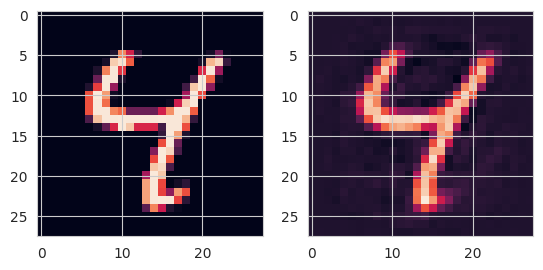

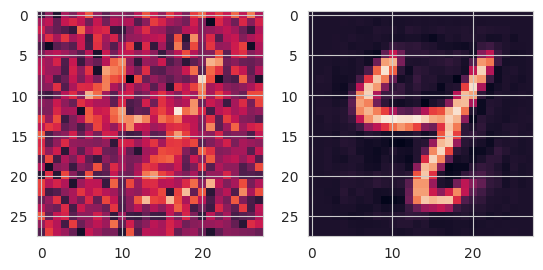

In [14]:
showEncodeDecode(dnauto_encode_decode_big, test_data_xy[6][0])
showEncodeDecode(dnauto_encode_decode_big, addNoise(test_data_xy[6][0]))

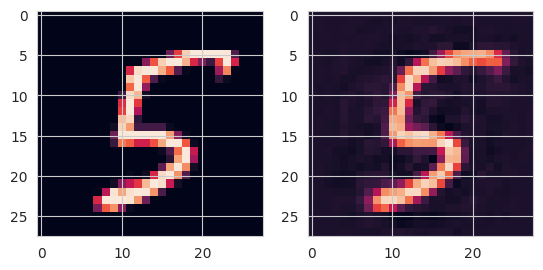

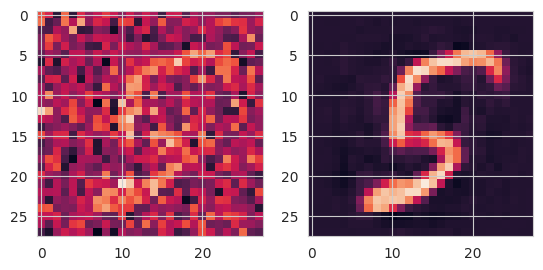

In [15]:
showEncodeDecode(dnauto_encode_decode_big, test_data_xy[23][0])
showEncodeDecode(dnauto_encode_decode_big, addNoise(test_data_xy[23][0]))

In [16]:
test_data_xy[6]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

### Sometimes people train deep autoencoders with weight sharing between the encoder and decoder. Try implementing a deep bottleneck autoencoder that uses the TransposeLinear layer for all of the decoder’s layers. Compare the weight shared versus the non-weight shared network when you have only n = 1,024, 8,192, 32,768, and all 60,000 samples from MNIST.

In [5]:
D = 28*28
n = 2
C = 1
classes = 10
mse_loss = nn.MSELoss()

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
class TransposeLinear(nn.Module):
    def __init__(self, linearLayer, bias=True):

        """
        linearLayer: is the layer that we want to use the transpose of to
        ➥ produce the output of this layer. So the Linear layer represents
        ➥ W, and this layer represents W^T. This is accomplished via
        ➥ weight sharing by reusing the weights of linearLayer
        bias: if True, we will create a new bias term b that is learned
        separately from what is in
        linearLayer. If false, we will not use any bias vector.
        """

        super().__init__()
        self.weight = linearLayer.weight

        if bias:
            self.bias = nn.Parameter(torch.Tensor(linearLayer.weight.shape[1]))
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        return F.linear(x, self.weight.t(), self.bias)


In [8]:
from torch.utils.data import Sampler

class ListSampler(Sampler):
    def __init__(self, mask):
        self.indices = list(range(len(mask)))
        self.mask = mask

    def __iter__(self):
        return (self.indices[i] for i in torch.nonzero(torch.as_tensor(self.mask)))

    def __len__(self):
        return len(self.mask)


In [9]:
linearLayer1 = nn.Linear(D, D//2)
linearLayer2 = nn.Linear(D//2, D//3)
linearLayer3 = nn.Linear(D//3, D//4)
linearLayer4 = nn.Linear(D//4, n)

auto_encoder_tl = nn.Sequential(
    nn.Flatten(),
    linearLayer1,
    nn.BatchNorm1d(D//2),
    nn.ReLU(),
    linearLayer2,
    nn.BatchNorm1d(D//3),
    nn.ReLU(),
    linearLayer3,
    nn.BatchNorm1d(D//4),
    nn.ReLU(),
    linearLayer4,
)

auto_decoder_tl = nn.Sequential(
    TransposeLinear(linearLayer4, bias=False),
    TransposeLinear(linearLayer3, bias=False),
    TransposeLinear(linearLayer2, bias=False),
    TransposeLinear(linearLayer1, bias=False),
    View(-1, 1, 28, 28)
)
auto_encode_decode_tl = nn.Sequential(
    auto_encoder_tl,
    auto_decoder_tl
)

In [10]:
auto_encoder = nn.Sequential(
    nn.Flatten(),
    getLayer(D, D//2),
    getLayer(D//2, D//3),
    getLayer(D//3, D//4),
    nn.Linear(D//4, n),
)

auto_decoder = nn.Sequential(
    getLayer(n, D//4),
    getLayer(D//4, D//3),
    getLayer(D//3, D//2),

    nn.Linear(D//2, D),
    View(-1, 1, 28, 28)
)
auto_encode_decode = nn.Sequential(
    auto_encoder,
    auto_decoder
)

In [11]:
def mask_generator(x, n):
    return [True if i < x else False for i in range(0, n)]

mg = mask_generator(5, 11)
print(mg)

[True, True, True, True, True, False, False, False, False, False, False]


In [12]:
n = 60000
list_of_samplers = [ListSampler(mask_generator(1024, n)),
                    ListSampler(mask_generator(8192, n)),
                    ListSampler(mask_generator(32768, n)),
                    ListSampler(mask_generator(n,n)),]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

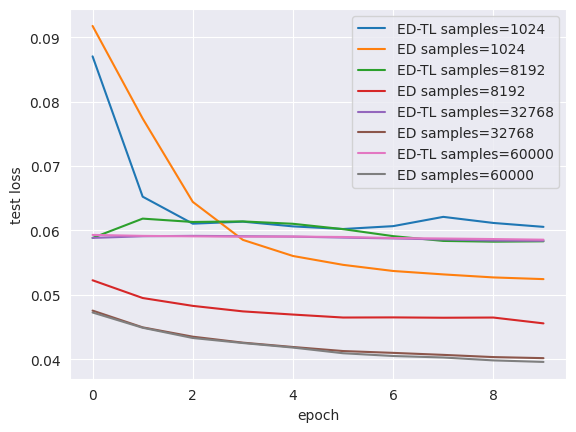

In [13]:
i = [1024, 8192, 32768, n]
j = 0
for sampler in list_of_samplers:
    train_data = AutoEncodeDataset(torchvision.datasets.MNIST("./data", train=True,transform=transforms.ToTensor(), download=True))

    test_data_xy = torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)
    test_data_xx = AutoEncodeDataset(test_data_xy)

    # shrink data with sampler
    train_loader = DataLoader(train_data, batch_size=128, shuffle=False, sampler=sampler)
    test_loader = DataLoader(test_data_xx, batch_size=128)

    result_tl = train_network(auto_encode_decode_tl, mse_loss, train_loader,test_loader=test_loader, epochs=10, device=device)
    auto_encode_decode_tl.apply(weight_reset)
    result = train_network(auto_encode_decode, mse_loss, train_loader,test_loader=test_loader, epochs=10, device=device)
    auto_encode_decode.apply(weight_reset)

    sns.lineplot(x='epoch', y='test loss', data=result_tl, label='ED-TL samples='+str(i[j]))
    sns.lineplot(x='epoch', y='test loss', data=result, label='ED samples='+str(i[j]))
    j+=1


### Challenging: Train an asymmetric denoising autoencoder for MNIST where the encoder is a fully connected network and the decoder is a convolutional network. Hint: You will need to end the encoder with a View layer that changes the shape from (B, D) to (B, C,28,28), where B is the number of neurons in the last nn.LinearLayer of the encoder and D = C ⋅ 28 ⋅ 28. Do the results of this network look better or worse than the fully connected network in the chapter, and how do you think intermixing architectures impacts that result?

In [5]:
D = 28*28
H = 8
n = 2
C = 1
classes = 10
mse_loss = nn.MSELoss()

In [6]:
train_data = AutoEncodeDataset(torchvision.datasets.MNIST("./data", train=True,transform=transforms.ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

In [7]:
normal = torch.distributions.Normal(0, 0.5)

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
def getLayerConv(in_size, out_size):
    """
    in_size: how many neurons/features are coming into this layer
    out_size: how many neurons/outputs this hidden layer should produce
    """
    return nn.Sequential(
        nn.Conv2d(in_size, out_size, kernel_size=3, padding=3//2),
        nn.BatchNorm2d(out_size),
        nn.ReLU())

In [10]:
def addNoise(x, device='cpu'):
    """
    We will use this helper function to add noise to some data.
    x: the data we want to add noise to
    device: the CPU or GPU that the input is located on.
    """
    return x + normal.sample(sample_shape= torch.Size(x.shape)).to(device)

In [11]:
class AdditiveGaussNoise(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        if self.training:
            return addNoise(x, device=device)
        else:
            return x

In [12]:
dnauto_encoder_big = nn.Sequential(
    nn.Flatten(),
    AdditiveGaussNoise(),
    getLayer(D, D*2),
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    nn.Linear(D*2, D*2),
    View(-1, C, 28, 28) # apply hint
)

dnauto_decoder_big = nn.Sequential(
    getLayerConv(C, H*2),
    getLayerConv(H*2, H),
    nn.Conv2d(H, 1, kernel_size=3, padding=3//2),
    nn.Flatten(),
    nn.Linear(D, D//2),
    View(-1, 1, 28, 28)
)

dnauto_encode_decode_big_mix = nn.Sequential(
    dnauto_encoder_big,
    dnauto_decoder_big
)

result = train_network(dnauto_encode_decode_big_mix, mse_loss, train_loader, test_loader=test_loader, epochs=30, device=device)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

In [13]:
def showEncodeDecode(encode_decode, x):
    """
    encode_decode: the PyTorch Module that does the encoding and decoding
    ➥ steps at once
    x: the input to plot as is, and after encoding & decoding it
    """

    encode_decode = encode_decode.eval()
    encode_decode = encode_decode.cpu()
    with torch.no_grad():
        tensor4d=x.unsqueeze(1) #add new dimension at position 1
        x_recon = encode_decode(tensor4d.cpu())
        #x_recon = encode_decode(x.cpu())

    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0,:])
    axarr[1].imshow(x_recon.numpy()[0,0,:])


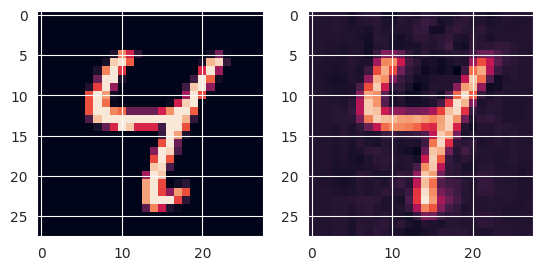

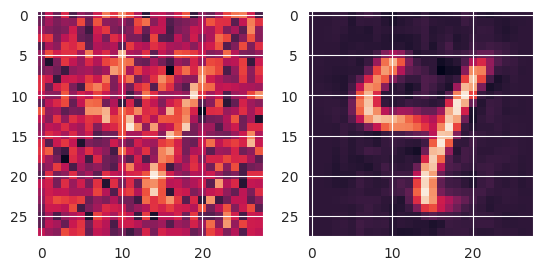

In [14]:
showEncodeDecode(dnauto_encode_decode_big_mix, test_data_xy[6][0])
showEncodeDecode(dnauto_encode_decode_big_mix, addNoise(test_data_xy[6][0]))

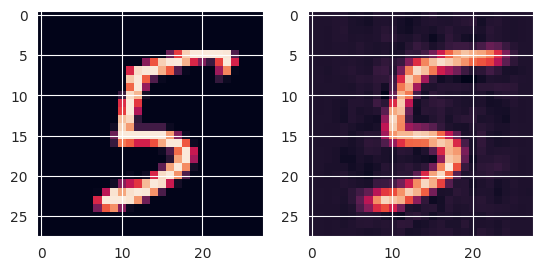

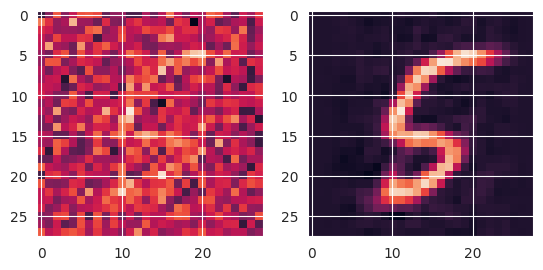

In [15]:
showEncodeDecode(dnauto_encode_decode_big_mix, test_data_xy[23][0])
showEncodeDecode(dnauto_encode_decode_big_mix, addNoise(test_data_xy[23][0]))

It looks a little bit worse. More epochs deliver a better result, however some details like curves got lost but it preforms well

### Challenging: Reshape the MNIST dataset as a sequence of pixels, and train an autoregressive model over the pixels. This requires using real-valued inputs and outputs, so you will not use an nn.Embedding layer, and you will need to switch to the MSE loss function. After training, try generating multiple digits from this autoregressive pixel model.

In [5]:
D = 28*28
H = 8
n = 2
C = 1
classes = 10
mse_loss = nn.MSELoss()

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
# modify Encode Dataset
# to be used instead of AutoRegressiveDataset because we have already digits instead of letters (no need for encoding)
class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs.
    This makes it easy to reuse other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        x = x.view(1, D) # apply x.view based on https://discuss.pytorch.org/t/missing-reshape-in-torchvision/9452/6
        return x, x

In [8]:
class AutoRegressive(nn.Module):
    def __init__(self, vec_size, hidden_size, layers=1): # self, num_embeddings, embd_size, hidden_size, layers=1
        super(AutoRegressive, self).__init__()
        self.hidden_size = hidden_size
        # self.embd = nn.Embedding(num_embeddings, embd_size) # << useless
        self.layers = nn.ModuleList([nn.GRUCell(vec_size, hidden_size)] +
                                     [nn.GRUCell(hidden_size, hidden_size) for i in range(layers-1)])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for i in range(layers)])

        self.pred_class = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),# (B, *, D)
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size), # (B, *, D)
            nn.Linear(hidden_size, vec_size) #(B, *. D) -> B(B, *, Vector)
        )

    def initHiddenStates(self, B):
        """
        Creates an initial hidden state list for the RNN layers.

        B: the batch size for the hidden states.
        """
        return [torch.zeros(B, self.hidden_size, device=device) for _ in range(len(self.layers))]

    def step(self, x_in, h_prevs=None):
        """
        x_in: the input for this current time step and has shape (B) if the values need
            to be embedded, and (B, D) if they have already been embedded.

        h_prevs: a list of hidden state tensors each with shape (B, self.hidden_size) for each
            layer in the network. These contain the current hidden state of the RNN layers and
            will be updated by this call.
        """
        #Prep all three arguments to be in the final form
        if len(x_in.shape) == 1: #(B), we need to embed it
            #x_in = self.embd(x_in) #now (B, D)
            x_in = x_in

        if h_prevs is None:
            h_prevs = self.initHiddenStates(x_in.shape[0])

        #Process the input
        for l in range(len(self.layers)):
            h_prev = h_prevs[l]
            h = self.norms[l](self.layers[l](x_in, h_prev))

            h_prevs[l] = h
            x_in = h
        #Make predictions about the token
        return self.pred_class(x_in)

    def forward(self, input):
        #Input should be (B, T)
        #What is the batch size?
        B = input.size(0)
        #What is the max number of time steps?
        T = input.size(1)


        #x = self.embd(input) #(B, T, D)
        x = input #(B, T, D)

        #Initial hidden states
        h_prevs = self.initHiddenStates(B)

        last_activations = []
        for t in range(T):
            x_in = x[:,t,:] #(B, D)
            last_activations.append(self.step(x_in, h_prevs))

        last_activations = torch.stack(last_activations, dim=1) #(B, T, D)


        return last_activations

In [9]:
train_data = AutoEncodeDataset(torchvision.datasets.MNIST("./data", train=True,transform=transforms.ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

In [10]:
autoReg_model = AutoRegressive(1*D, 128, layers=2)
autoReg_model = autoReg_model.to(device)

for p in autoReg_model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

In [11]:
def MSELossTime(x, y):
    """
    x: output with shape (B, T, V)
    y: labels with shape (B, T)

    """
    cel = nn.MSELoss()

    T = x.size(1)

    loss = 0

    for t in range(T):#for every item in the sequence
        loss += cel(x[:,t,:], y[:,t]) #Compute the sum of prediction errors

    return loss

In [12]:
result = train_network(autoReg_model, MSELossTime, train_loader, epochs=20, device=device)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

original shape: torch.Size([1, 1, 784])


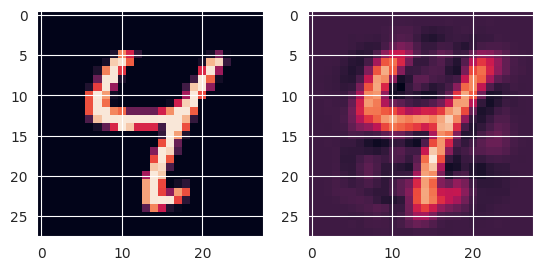

In [13]:
autoReg_model = autoReg_model.eval()
# test_data_xy contains images and labels. each image has a size of (28x28) = 784
# - 1st copy our tensor that contains our image to our gpu in my case it's a gpu
# - 2nd lets change the shape to 784
sampling = test_data_xy[6][0].to(device).view(1,1,784) # transform to (B, T, D)

with torch.no_grad():
    # get our prediction
    x_recon = autoReg_model(sampling) # only accepts (B, T, D)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(test_data_xy[6][0].numpy()[0, :])
axarr[1].imshow(x_recon.view(28,28).cpu().numpy()) # invalid shape without .view(28,28)
print("original shape: "+str(x_recon.shape))

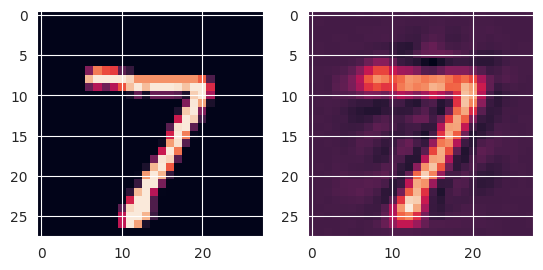

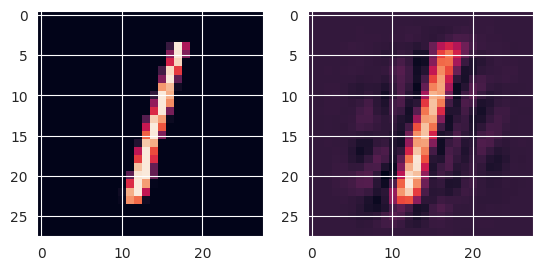

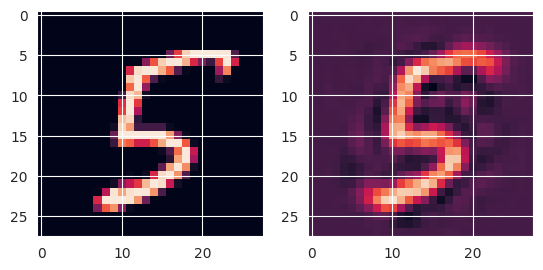

In [14]:
autoReg_model = autoReg_model.eval()
samples = [test_data_xy[0][0], test_data_xy[2][0], test_data_xy[23][0]]

for sample in samples:
    sampling = sample.to(device).view(1,1,784) # transform to (B, T, D)

    with torch.no_grad():
        # get our prediction
        x_recon = autoReg_model(sampling) # only accepts (B, T, D)

    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(sample.numpy()[0, :])
    axarr[1].imshow(x_recon.view(28,28).cpu().numpy())


### Convert the GRUCells in the autoregressive model to LSTMCells, and train a new model. Which one do you think has better generated output?

In [5]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

all_data = []
resp = urlopen("https://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt")
shakespear_100k = resp.read()
shakespear_100k = shakespear_100k.decode('utf-8').lower()

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
vocab2indx = {} #the vocab $\Sigma$
for char in shakespear_100k:
    if char not in vocab2indx: #add every new character to the vocab
        vocab2indx[char] = len(vocab2indx) #set the index based on the current vocab size

#Some useful code to goe from index back to original characters.
indx2vocab = {}
#Well simply iterate over all key,value pairs and create a dicionary with the inverse mapping.
for k, v in vocab2indx.items():
    indx2vocab[v] = k
print("Vocab Size: ", len(vocab2indx))
print("Total Characters:", len(shakespear_100k))

Vocab Size:  36
Total Characters: 99993


In [8]:
class AutoRegressiveDataset(Dataset):
    """
    Creates an autoregressive dataset from one single, long, source sequence by breaking it up into "chunks".
    """

    def __init__(self, large_string, MAX_CHUNK=500):
        """
        large_string: the original long source sequence that chunks will be extracted from
        MAX_CHUNK: the maximum allowed size of any chunk.
        """
        self.doc = large_string
        self.MAX_CHUNK = MAX_CHUNK

    def __len__(self):
        #The number of items is the number of characters divided by chunk size
        return (len(self.doc)-1) // self.MAX_CHUNK

    def __getitem__(self, idx):
        #Compute the starting position for the idx'th chunk
        start = idx*self.MAX_CHUNK
        #Grab the input sub-string
        sub_string = self.doc[start:start+self.MAX_CHUNK]
        #convert the sub-string into integers based on our vocab
        x = [vocab2indx[c] for c in sub_string]

        #grab the label sub-string by shifting over by 1
        sub_string = self.doc[start+1:start+self.MAX_CHUNK+1]
        #convert the label sub-string into integers based on our vocab
        y = [vocab2indx[c] for c in sub_string]
        #convert the
        return torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)
#Caption: Creating a dataset for autoregressive problems from a large text corpus. We assume the corpus exists as one long string, and it is OK to concatenate multiple files together into one long string since our chunks are smaller than most documents are anyway.

In [9]:
class AutoRegressive(nn.Module):

    def __init__(self, num_embeddings, embd_size, hidden_size, layers=1):
        super(AutoRegressive, self).__init__()
        self.hidden_size = hidden_size
        self.embd = nn.Embedding(num_embeddings, embd_size)
        self.layers = nn.ModuleList([nn.LSTMCell(embd_size, hidden_size)] +
                                     [nn.LSTMCell(hidden_size, hidden_size) for i in range(layers-1)])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for i in range(layers)])

        self.pred_class = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),# (B, *, D)
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size), # (B, *, D)
            nn.Linear(hidden_size, num_embeddings) #(B, *. D) -> B(B, *, VocabSize)
        )

    def initHiddenStates(self, B):
        """
        Creates an initial hidden state list for the RNN layers.

        B: the batch size for the hidden states.
        """
        return [torch.zeros(B, self.hidden_size, device=device) for _ in range(len(self.layers))]

    def step(self, x_in, h_prevs=None):
        """
        x_in: the input for this current time step and has shape (B) if the values need
            to be embedded, and (B, D) if they have alreayd been embedded.

        h_prevs: a list of hidden state tensors each with shape (B, self.hidden_size) for each
            layer in the network. These contain the current hidden state of the RNN layers and
            will be updated by this call.
        """
        #Prep all three arguments to be in the final form
        if len(x_in.shape) == 1: #(B), we need to embed it
            x_in = self.embd(x_in) #now (B, D)

        if h_prevs is None:
            h_prevs = self.initHiddenStates(x_in.shape[0])

        #Process the input
        for l in range(len(self.layers)):
            h_prev = h_prevs[l]

            h = self.norms[l](self.layers[l](x_in, (h_prev, h_prev))[0])
            h_prevs[l] = h
            x_in = h
        #Make predictions about the token
        return self.pred_class(x_in)

    def forward(self, input):
        #Input should be (B, T)
        #What is the batch size?
        B = input.size(0)
        #What is the max number of time steps?
        T = input.size(1)

        x = self.embd(input) #(B, T, D)

        #Initial hidden states
        h_prevs = self.initHiddenStates(B)

        last_activations = []
        for t in range(T):
            x_in = x[:,t,:] #(B, D)
            last_activations.append(self.step(x_in, h_prevs))

        last_activations = torch.stack(last_activations, dim=1) #(B, T, D)

        return last_activations

In [10]:
autoRegData = AutoRegressiveDataset(shakespear_100k, MAX_CHUNK=250)
autoReg_loader = DataLoader(autoRegData, batch_size=128, shuffle=True)

autoReg_model = AutoRegressive(len(vocab2indx), 32, 128, layers=2)
autoReg_model = autoReg_model.to(device)

for p in autoReg_model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

In [11]:
def CrossEntLossTime(x, y):
    """
    x: output with shape (B, T, V)
    y: labels with shape (B, T)

    """
    cel = nn.CrossEntropyLoss()

    T = x.size(1)

    loss = 0

    for t in range(T):#for every item in the sequence
        loss += cel(x[:,t,:], y[:,t]) #Compute the sum of prediction errors

    return loss

In [12]:
train_network(autoReg_model, CrossEntLossTime, autoReg_loader, epochs=100, device=device)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

,epoch,total time,train loss
0,0,2.051538,916.654160
1,1,3.438019,845.347000
2,2,4.759883,805.682236
3,3,6.129481,786.270966
4,4,7.472734,771.978851
...,...,...,...
95,95,132.755589,463.429886
96,96,134.046367,463.312553
97,97,135.312603,461.838844
98,98,136.570927,463.918343


In [13]:
autoReg_model = autoReg_model.eval()
sampling = torch.zeros((1, 500), dtype=torch.int64, device=device)

In [14]:
seed = "EMILIA:".lower()
cur_len = len(seed)
sampling[0,0:cur_len] = torch.tensor([vocab2indx[x] for x in seed])

In [15]:
for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = autoReg_model(sampling[:,0:i]) #process all the previous items
        h = h[:,-1,:] #Grab the last time step
        h = F.softmax(h, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1) #sample the next prediction
        sampling[:,i] = next_tokens #set the next prediction
        #increase the length by one
        cur_len += 1

  0%|          | 0/493 [00:00<?, ?it/s]

In [16]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

emilia:
to hen for hurpout a tour mang:
my not goed weot you this reing thangs i cave count,
thow is gins
brost of my to: the shall sif, worttr good thy grattous,
for my exes of try cuctust for rome stes and goud nothen, and prove lordy for the dome, lard vang,
to 'the armant me has belew,-sy minem:
whee, hone hip hands's of it,
rity i sulmous mill the say you do a stile me have my my have
py rell'p with thined my to controut, but it you!
hand feful: lovin beatsold as i bady it's not i so ratish


Based on this output compared with your (form chapter 7) it seems that GRU performs better.
My generated text contains a lot of creepy stuff like repeated words, typos and some strange words

### The AutoRegressiveDataset can start an input in the middle of a sentence since it naively grabs subsequences of the input. Write a new version that will only select the start of a sequence at the start of a new line (i.e., after a carriage return ‘\n’) and then returns the next max_chunk characters (it’s OK if there is some overlap between chunks). Train a model on this new version of the dataset. Do you think it changes the characteristics of the generated output?

In [5]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

all_data = []
resp = urlopen("https://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt")
shakespear_100k = resp.read()
shakespear_100k = shakespear_100k.decode('utf-8').lower()

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
vocab2indx = {} #the vocab $\Sigma$
for char in shakespear_100k:
    if char not in vocab2indx: #add every new character to the vocab
        vocab2indx[char] = len(vocab2indx) #set the index based on the current vocab size

#Some useful code to goe from index back to original characters.
indx2vocab = {}
#Well simply iterate over all key,value pairs and create a dicionary with the inverse mapping.
for k, v in vocab2indx.items():
    indx2vocab[v] = k
print("Vocab Size: ", len(vocab2indx))
print("Total Characters:", len(shakespear_100k))

Vocab Size:  36
Total Characters: 99993


In [8]:
class AutoRegressiveDataset(Dataset):
    """
    Creates an autoregressive dataset from one single, long, source sequence by breaking it up into "chunks".
    """

    def __init__(self, large_string, MAX_CHUNK=500):
        """
        large_string: the original long source sequence that chunks will be extracted from
        MAX_CHUNK: the maximum allowed size of any chunk.
        """
        self.doc = large_string
        self.MAX_CHUNK = MAX_CHUNK

    def __len__(self):
        #The number of items is the number of characters divided by chunk size

        return (len(self.doc)-1) // self.MAX_CHUNK

    def __getitem__(self, idx):
        #Compute the starting position for the idx'th chunk
        indices = [i.start() for i in re.finditer('\n', self.doc)]
        #filter
        l = len(self.doc) - self.MAX_CHUNK
        indices = list(filter(lambda x: x < l, indices))


        start = indices[idx]
        #Grab the input sub-string
        sub_string = self.doc[start:start+self.MAX_CHUNK]
        #convert the sub-string into integers based on our vocab
        x = [vocab2indx[c] for c in sub_string]

        #grab the label sub-string by shifting over by 1
        sub_string = self.doc[start+1:start+self.MAX_CHUNK+1]
        #convert the label sub-string into integers based on our vocab
        y = [vocab2indx[c] for c in sub_string]
        #convert the
        return torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)
#Caption: Creating a dataset for autoregressive problems from a large text corpus. We assume the corpus exists as one long string, and it is OK to concatenate multiple files together into one long string since our chunks are smaller than most documents are anyway.

In [9]:
class AutoRegressive(nn.Module):

    def __init__(self, num_embeddings, embd_size, hidden_size, layers=1):
        super(AutoRegressive, self).__init__()
        self.hidden_size = hidden_size
        self.embd = nn.Embedding(num_embeddings, embd_size)
        self.layers = nn.ModuleList([nn.LSTMCell(embd_size, hidden_size)] +
                                     [nn.LSTMCell(hidden_size, hidden_size) for i in range(layers-1)])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for i in range(layers)])

        self.pred_class = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),# (B, *, D)
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size), # (B, *, D)
            nn.Linear(hidden_size, num_embeddings) #(B, *. D) -> B(B, *, VocabSize)
        )

    def initHiddenStates(self, B):
        """
        Creates an initial hidden state list for the RNN layers.

        B: the batch size for the hidden states.
        """
        return [torch.zeros(B, self.hidden_size, device=device) for _ in range(len(self.layers))]

    def step(self, x_in, h_prevs=None):
        """
        x_in: the input for this current time step and has shape (B) if the values need
            to be embedded, and (B, D) if they have alreayd been embedded.

        h_prevs: a list of hidden state tensors each with shape (B, self.hidden_size) for each
            layer in the network. These contain the current hidden state of the RNN layers and
            will be updated by this call.
        """
        #Prep all three arguments to be in the final form
        if len(x_in.shape) == 1: #(B), we need to embed it
            x_in = self.embd(x_in) #now (B, D)

        if h_prevs is None:
            h_prevs = self.initHiddenStates(x_in.shape[0])

        #Process the input
        for l in range(len(self.layers)):
            h_prev = h_prevs[l]

            h = self.norms[l](self.layers[l](x_in, (h_prev, h_prev))[0])
            h_prevs[l] = h
            x_in = h
        #Make predictions about the token
        return self.pred_class(x_in)

    def forward(self, input):
        #Input should be (B, T)
        #What is the batch size?
        B = input.size(0)
        #What is the max number of time steps?
        T = input.size(1)

        x = self.embd(input) #(B, T, D)

        #Initial hidden states
        h_prevs = self.initHiddenStates(B)

        last_activations = []
        for t in range(T):
            x_in = x[:,t,:] #(B, D)
            last_activations.append(self.step(x_in, h_prevs))

        last_activations = torch.stack(last_activations, dim=1) #(B, T, D)

        return last_activations

In [10]:
autoRegData = AutoRegressiveDataset(shakespear_100k, MAX_CHUNK=250)
autoReg_loader = DataLoader(autoRegData, batch_size=128, shuffle=True)

autoReg_model = AutoRegressive(len(vocab2indx), 32, 128, layers=2)
autoReg_model = autoReg_model.to(device)

for p in autoReg_model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

In [11]:
def CrossEntLossTime(x, y):
    """
    x: output with shape (B, T, V)
    y: labels with shape (B, T)

    """
    cel = nn.CrossEntropyLoss()

    T = x.size(1)

    loss = 0

    for t in range(T):#for every item in the sequence
        loss += cel(x[:,t,:], y[:,t]) #Compute the sum of prediction errors

    return loss

In [12]:
train_network(autoReg_model, CrossEntLossTime, autoReg_loader, epochs=100, device=device)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

,epoch,total time,train loss
0,0,3.370399,901.067551
1,1,5.023897,832.705917
2,2,6.658252,791.245270
3,3,8.412615,775.977417
4,4,10.039689,770.882034
...,...,...,...
95,95,162.975562,351.690254
96,96,164.755668,341.245712
97,97,166.424842,334.786575
98,98,168.088210,326.113655


In [13]:
autoReg_model = autoReg_model.eval()
sampling = torch.zeros((1, 500), dtype=torch.int64, device=device)

In [14]:
seed = "EMILIA:".lower()
cur_len = len(seed)
sampling[0, 0:cur_len] = torch.tensor([vocab2indx[x] for x in seed])

In [15]:
for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = autoReg_model(sampling[:, 0:i])  #process all the previous items
        h = h[:, -1, :]  #Grab the last time step
        h = F.softmax(h, dim=1)  #make probabilities
        next_tokens = torch.multinomial(h, 1)  #sample the next prediction
        sampling[:, i] = next_tokens  #set the next prediction
        #increase the length by one
        cur_len += 1

  0%|          | 0/493 [00:00<?, ?it/s]

In [16]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

emilia:mtnshepmiieeameptsmraftpsisoiinfnmwiiooonw hsw;other hou? greatietinowe nobkilattow:, contiiod know shat ow
hy; be the shal had man, fir the and your to by ateeny, a shoumery duenu talley., pist so prige of sinfer and usgland, toou lormplutmer'l be land, to 'il warm then your beart,-s cainteralt:
thou
andiile ame on i ie, rity theu mor mail no evis ay parteas, plesid hame from that i yor heretr ape usebant;
to cibntous, bruttants, an this foon. have beango dour from fece's notale
our ther


Performs more wore and generated text seems to be useless :(

### After training your autoregressive model on sentences, use the LastTimeStep class to extract a feature vector representing each sentence. Then feed these vectors into your favorite clustering algorithm and see if you can find any groups of similar styles or types of sentences. Note: You may want to sub-sample a smaller number of sentences to make your clustering algorithm run faster.

In [6]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re
from idlmam import LastTimeStep, EmbeddingPackable

all_data = []
resp = urlopen("https://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt")
shakespear_100k = resp.read()
shakespear_100k = shakespear_100k.decode('utf-8').lower()

In [7]:
vocab2indx = {} #the vocab $\Sigma$
for char in shakespear_100k:
    if char not in vocab2indx: #add every new character to the vocab
        vocab2indx[char] = len(vocab2indx) #set the index based on the current vocab size

#Some useful code to goe from index back to original characters.
indx2vocab = {}
#Well simply iterate over all key,value pairs and create a dicionary with the inverse mapping.
for k, v in vocab2indx.items():
    indx2vocab[v] = k
print("Vocab Size: ", len(vocab2indx))
print("Total Characters:", len(shakespear_100k))

Vocab Size:  36
Total Characters: 99993


In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")

In [9]:
class AutoRegressiveDataset(Dataset):
    """
    Creates an autoregressive dataset from one single, long, source sequence by breaking it up into "chunks".
    """

    def __init__(self, large_string, MAX_CHUNK=500):
        """
        large_string: the original long source sequence that chunks will be extracted from
        MAX_CHUNK: the maximum allowed size of any chunk.
        """
        self.doc = large_string
        self.MAX_CHUNK = MAX_CHUNK

    def __len__(self):
        #The number of items is the number of characters divided by chunk size
        return (len(self.doc)-1) // self.MAX_CHUNK

    def __getitem__(self, idx):
        #Compute the starting position for the idx'th chunk
        start = idx*self.MAX_CHUNK
        #Grab the input sub-string
        sub_string = self.doc[start:start+self.MAX_CHUNK]
        #convert the sub-string into integers based on our vocab
        x = [vocab2indx[c] for c in sub_string]

        #grab the label sub-string by shifting over by 1
        sub_string = self.doc[start+1:start+self.MAX_CHUNK+1]
        #convert the label sub-string into integers based on our vocab
        y = [vocab2indx[c] for c in sub_string]
        #convert the
        return torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)

In [10]:
class AutoRegressive(nn.Module):

    def __init__(self, num_embeddings, embd_size, hidden_size, layers=1):
        super(AutoRegressive, self).__init__()
        self.hidden_size = hidden_size
        self.embd = nn.Embedding(num_embeddings, embd_size)
        self.layers = nn.ModuleList([nn.GRUCell(embd_size, hidden_size)] +
                                     [nn.GRUCell(hidden_size, hidden_size) for i in range(layers-1)])
        #self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for i in range(layers)])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for i in range(layers)])
        self.feature_vec = []
        self.lts = nn.Sequential(nn.RNN(embd_size, hidden_size, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
                                  LastTimeStep(rnn_layers=3))
        # self.lts = nn.ModuleList([#EmbeddingPackable(nn.Embedding(num_embeddings, embd_size)), #(B, T) -> (B, T, D)
        #                           nn.RNN(embd_size, hidden_size, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
        #                           LastTimeStep(rnn_layers=3)])

        self.pred_class = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),# (B, *, D)
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size), # (B, *, D)
            nn.Linear(hidden_size, num_embeddings), #(B, *. D) -> B(B, *, VocabSize)
        )

    def initHiddenStates(self, B):
        """
        Creates an initial hidden state list for the RNN layers.

        B: the batch size for the hidden states.
        """
        return [torch.zeros(B, self.hidden_size, device=device) for _ in range(len(self.layers))]

    def step(self, x_in, h_prevs=None):
        """
        x_in: the input for this current time step and has shape (B) if the values need
            to be embedded, and (B, D) if they have alreayd been embedded.

        h_prevs: a list of hidden state tensors each with shape (B, self.hidden_size) for each
            layer in the network. These contain the current hidden state of the RNN layers and
            will be updated by this call.
        """
        #Prep all three arguments to be in the final form
        if len(x_in.shape) == 1: #(B), we need to embed it
            x_in = self.embd(x_in) #now (B, D)

        if h_prevs is None:
            h_prevs = self.initHiddenStates(x_in.shape[0])

        self.feature_vec.append(self.lts(x_in))

        #Process the input
        for l in range(len(self.layers)):
            h_prev = h_prevs[l]
            h = self.norms[l](self.layers[l](x_in, h_prev))

            h_prevs[l] = h
            x_in = h
        #Make predictions about the token
        return self.pred_class(x_in)

    def forward(self, input):
        #Input should be (B, T)
        #What is the batch size?
        B = input.size(0)
        #What is the max number of time steps?
        T = input.size(1)

        x = self.embd(input) #(B, T, D)

        #Initial hidden states
        h_prevs = self.initHiddenStates(B)

        last_activations = []
        for t in range(T):
            x_in = x[:,t,:] #(B, D)
            last_activations.append(self.step(x_in, h_prevs))

        last_activations = torch.stack(last_activations, dim=1) #(B, T, D)

        return last_activations

In [11]:
autoRegData = AutoRegressiveDataset(shakespear_100k, MAX_CHUNK=250)
autoReg_loader = DataLoader(autoRegData, batch_size=128, shuffle=True)

autoReg_model = AutoRegressive(len(vocab2indx), 32, 128, layers=2)
autoReg_model = autoReg_model.to(device)

for p in autoReg_model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

In [12]:
def CrossEntLossTime(x, y):
    """
    x: output with shape (B, T, V)
    y: labels with shape (B, T)

    """
    cel = nn.CrossEntropyLoss()

    T = x.size(1)

    loss = 0

    for t in range(T):#for every item in the sequence
        loss += cel(x[:,t,:], y[:,t]) #Compute the sum of prediction errors

    return loss

In [13]:
train_network(autoReg_model, CrossEntLossTime, autoReg_loader, epochs=10, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

,epoch,total time,train loss
0,0,1.878836,879.921310
1,1,3.670581,801.023636
2,2,5.472048,773.814743
3,3,7.278978,765.463120
4,4,9.163742,759.904831
5,5,10.949125,760.014908
6,6,12.821784,756.198776
7,7,14.720881,755.756699
8,8,16.522082,753.559097
9,9,18.370517,750.286057


In [14]:
autoReg_model = autoReg_model.eval()
feature_vec = autoReg_model.feature_vec

In [15]:
from sklearn.cluster import KMeans
import numpy as np

# transform input dataset
#l = np.array([[idx, v.cpu().detach().numpy()] for idx, v in enumerate(feature_vec)], dtype='object')
#test_dataset = [v.cpu().detach().numpy() for v in feature_vec]

test_data = np.array([v.cpu().detach().numpy() for v in feature_vec])
nsamples, nx, ny = test_data.shape
test_dataset = test_data.reshape((nsamples, nx*ny))

#nsamples = l.shape[0]
#test_dataset = test_data_xy.data.numpy().reshape((nsamples,nx*ny))
#
kmeans = KMeans(n_clusters=100, random_state=42, algorithm='lloyd').fit(test_dataset)
# #kmeans.labels_
y_pred_test = kmeans.predict(test_dataset)

In [16]:
print(type(y_pred_test))
y_pred_test

<class 'numpy.ndarray'>


array([92, 43, 74, ..., 29, 93, 15], dtype=int32)

In [17]:
print(type(test_dataset))
print(test_dataset.shape)
labels = y_pred_test.reshape((nsamples, 1))
print(labels.shape)
print(type(labels))

<class 'numpy.ndarray'>
(10000, 128)
(10000, 1)
<class 'numpy.ndarray'>


In [18]:
data = np.hstack((test_dataset, labels))
df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,0.293272,0.037886,-0.282410,-0.093083,-0.034567,0.222803,-0.101641,-0.046342,-0.044993,0.033089,...,-0.137857,-0.284014,-0.038534,-0.452820,0.176990,0.233908,0.123286,0.056491,0.112797,92.0
1,0.048289,0.222849,0.112521,-0.153085,-0.058004,0.366281,-0.107648,0.019891,0.114608,-0.158583,...,-0.084581,-0.292535,-0.122639,-0.456774,0.030820,0.029195,0.058333,0.152833,0.113439,43.0
2,0.019607,0.377354,-0.114081,-0.215720,-0.049485,0.337900,0.233233,-0.224382,0.125259,-0.117715,...,-0.053887,-0.268352,-0.204711,-0.316096,0.138372,0.116157,-0.002958,0.041869,0.241033,74.0
3,0.060324,-0.022236,0.028960,0.037483,-0.261859,0.355232,-0.020525,-0.194524,0.002200,-0.329672,...,0.021046,-0.501215,-0.095419,-0.389922,0.023885,-0.062101,0.065058,-0.138344,0.081953,62.0
4,0.085102,0.193957,-0.006121,-0.131038,-0.265010,0.015043,-0.338645,0.036301,0.151101,-0.243836,...,0.025794,-0.323508,-0.096067,-0.224624,-0.120887,0.125386,-0.024857,-0.007234,-0.070415,79.0


In [19]:
df.iloc[:,[128]].value_counts()

128 
22.0    162
3.0     151
70.0    147
98.0    145
7.0     143
       ... 
75.0     57
58.0     57
91.0     54
77.0     50
19.0     42
Length: 100, dtype: int64

In [20]:
#df2 = df.iloc[:,[128]].value_counts()
#print(df2.index.values[0])# .to_numpy()[0][0])

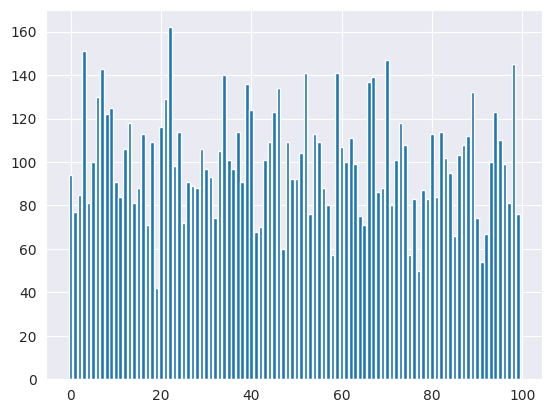

In [21]:
# we have 10K of scentences and 100 clusters
df2 = df.iloc[:,[128]].value_counts()
classes = [t[0] for t in df2.index.values]
# lest show how often each class occurs
plt.bar(classes, df2.values)
plt.show()

In [22]:
# lest find that class that occurs > 160 times
df2[df2.values > 160]

128 
22.0    162
dtype: int64

In [23]:
# get numbers of sentences
#df[df.iloc[:, 128] == 22.0]
sentences = df[df.iloc[:, 128] == 22.0].index.values.tolist()
print("ids of sentences: \n"+str(sentences))


ids of sentences: 
[43, 378, 445, 451, 603, 658, 661, 863, 909, 953, 960, 1019, 1064, 1176, 1209, 1281, 1294, 1377, 1563, 1631, 1722, 1742, 1805, 1823, 1848, 1893, 1969, 2007, 2079, 2105, 2131, 2224, 2324, 2413, 2426, 2598, 2602, 2666, 2742, 2748, 2808, 2830, 2858, 2878, 2976, 2999, 3007, 3029, 3057, 3092, 3224, 3230, 3240, 3269, 3521, 3591, 3612, 3695, 3702, 3723, 3794, 3809, 3824, 3837, 3915, 4011, 4180, 4201, 4227, 4295, 4319, 4382, 4515, 4546, 4634, 4668, 4766, 4777, 4788, 4806, 4827, 4940, 4958, 4965, 4993, 5009, 5051, 5112, 5128, 5133, 5161, 5229, 5255, 5268, 5321, 5392, 5454, 5560, 5736, 5808, 5865, 5916, 5930, 5953, 6091, 6285, 6348, 6408, 6432, 6462, 6511, 6539, 6645, 6689, 6706, 6752, 6801, 6811, 6835, 6865, 6873, 6957, 6970, 6985, 7001, 7109, 7158, 7245, 7311, 7403, 7478, 7639, 7742, 7749, 7987, 7995, 8012, 8234, 8247, 8407, 8414, 8431, 8601, 8639, 8715, 8803, 8868, 8942, 8990, 9030, 9084, 9134, 9146, 9210, 9449, 9474, 9624, 9632, 9719, 9894, 9952, 9969]
